In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
df= pd.read_csv('df7.csv', parse_dates=['Date'])
df = df.rename(columns = {"Date":"ds","Close":"y"}) 
df 

,ds,y,tby,ffr,fta,eps,div,une,vix
0,2005-06-20,1216.10,4.11,3.04,812235.0,84.81,1.76,5.0,148.30
1,2005-06-21,1213.61,4.06,3.04,812235.0,84.81,1.76,5.0,149.00
2,2005-06-22,1213.88,3.95,3.04,811179.0,84.81,1.76,5.0,148.40
3,2005-06-23,1200.73,3.96,3.04,811179.0,84.81,1.76,5.0,150.50
4,2005-06-24,1191.57,3.92,3.04,811179.0,84.81,1.76,5.0,152.00
...,...,...,...,...,...,...,...,...,...
3893,2021-01-25,3855.36,1.05,0.09,7414942.0,95.72,1.58,6.3,25.85
3894,2021-01-26,3849.62,1.05,0.09,7414942.0,95.72,1.58,6.3,25.30
3895,2021-01-27,3750.77,1.04,0.09,7404926.0,95.72,1.58,6.3,33.05
3896,2021-01-28,3787.38,1.07,0.09,7404926.0,95.72,1.58,6.3,30.49


In [3]:
from datetime import datetime
p = 0.9
# Train around 90% of dataset 
# cutoff = int((p*len(df)//100)*100)
cutoff = int(p*len(df))
df_train = df[:cutoff].copy()
df_test = df.drop(df_train.index).copy()

print(df_train, df_test)

             ds        y   tby   ffr        fta     eps   div  une     vix
0    2005-06-20  1216.10  4.11  3.04   812235.0   84.81  1.76  5.0  148.30
1    2005-06-21  1213.61  4.06  3.04   812235.0   84.81  1.76  5.0  149.00
2    2005-06-22  1213.88  3.95  3.04   811179.0   84.81  1.76  5.0  148.40
3    2005-06-23  1200.73  3.96  3.04   811179.0   84.81  1.76  5.0  150.50
4    2005-06-24  1191.57  3.92  3.04   811179.0   84.81  1.76  5.0  152.00
...         ...      ...   ...   ...        ...     ...   ...  ...     ...
3503 2019-07-02  2973.01  1.98  2.40  3826817.0  139.88  1.94  3.6   14.25
3504 2019-07-03  2995.82  1.96  2.40  3813198.0  139.88  1.94  3.6   14.00
3505 2019-07-05  2990.41  2.04  2.40  3813198.0  139.88  1.94  3.6   14.35
3506 2019-07-08  2975.95  2.05  2.40  3813198.0  139.88  1.94  3.6   14.85
3507 2019-07-09  2979.63  2.07  2.40  3813198.0  139.88  1.94  3.6   14.90

[3508 rows x 9 columns]              ds        y   tby   ffr        fta     eps   div  une    vix
3

In [7]:
tmp_pred_periods =100 # predicted periods 
start = int(tmp_pred_periods * (p*10) + len(df_train) % tmp_pred_periods)
num_winds = int((df_train.shape[0]-start)/tmp_pred_periods)
print(start, num_winds)

908.0 26


In [6]:
#prophet part 
from fbprophet import Prophet
pro_pred = []

# use accumulated data to predict the next pred_size data
for i in range(num_winds):
    tmp_train = df_train.iloc[: start+ i*tmp_pred_periods].copy()
    
    fbp = Prophet(daily_seasonality=True)
    # fit close price using fbprophet model
    fbp.fit(tmp_train[['ds','y']])
    
    # predict pred_size futures and get the forecast price 
    fut = fbp.make_future_dataframe(periods = tmp_pred_periods)
    tmp_forecast = fbp.predict(fut) 
    if (i == 0):
        pro_pred.append(tmp_forecast[:start].yhat)
      
    # only require the forcast on test data of temporary training data
    pred = tmp_forecast[start+ i*tmp_pred_periods:].yhat
    pro_pred.append(pred)

In [8]:
pro_pred

[0      1191.449597
 1      1191.955579
 2      1191.695653
 3      1190.749328
 4      1190.746134
           ...     
 903     792.985043
 904     787.694401
 905     787.229874
 906     786.004200
 907     784.046310
 Name: yhat, Length: 908, dtype: float64,
 908     782.935133
 909     788.188834
 910     787.016754
 911     779.113534
 912     778.703970
            ...    
 1003    656.749575
 1004    654.318998
 1005    651.008823
 1006    648.459740
 1007    652.253377
 Name: yhat, Length: 100, dtype: float64,
 1008    842.154306
 1009    840.350023
 1010    839.164840
 1011    855.279566
 1012    853.925228
            ...    
 1103    637.431424
 1104    613.112298
 1105    607.678714
 1106    601.670427
 1107    595.624851
 Name: yhat, Length: 100, dtype: float64,
 1108    1077.492133
 1109    1079.130123
 1110    1080.727401
 1111    1082.991681
 1112    1080.947954
            ...     
 1203    1072.407782
 1204    1069.415767
 1205    1070.151681
 1206    1067.702026
 120

In [10]:
flat_pro_pred = [item for l1 in pro_pred for item in l1]

In [13]:
print(len(flat_pro_pred),len(df_train))

3508 3508


In [14]:
df_train['fbsp'] = pd.Series(flat_pro_pred)

In [18]:
from fbprophet import Prophet
pred_periods = int((1-p)* len(df))
fbp = Prophet(daily_seasonality=True)
# fit close price using fbprophet model
fbp.fit(df_train[['ds','y']])
    
 # predict pred_size futures and get the forecast price 
fut = fbp.make_future_dataframe(periods = pred_periods)
forecast = fbp.predict(fut) 

In [21]:
df_test['fbsp'] = forecast.loc[cutoff:, 'yhat']

In [23]:
df_test = df_test.dropna()
df_test

,ds,y,tby,ffr,fta,eps,div,une,vix,fbsp
3508,2019-07-10,2993.07,2.07,2.40,3815038.0,139.88,1.94,3.6,14.10,2956.281317
3509,2019-07-11,2999.91,2.13,2.40,3815038.0,139.88,1.94,3.6,13.70,2958.524203
3510,2019-07-12,3013.77,2.12,2.40,3815038.0,139.88,1.94,3.6,13.12,2960.942015
3511,2019-07-15,3014.30,2.09,2.40,3815038.0,139.88,1.94,3.6,12.91,2961.954607
3512,2019-07-16,3004.04,2.13,2.40,3815038.0,139.88,1.94,3.6,12.90,2964.083755
...,...,...,...,...,...,...,...,...,...,...
3892,2021-01-22,3841.47,1.10,0.09,7414942.0,95.72,1.58,6.3,24.85,3241.237695
3893,2021-01-25,3855.36,1.05,0.09,7414942.0,95.72,1.58,6.3,25.85,3240.331223
3894,2021-01-26,3849.62,1.05,0.09,7414942.0,95.72,1.58,6.3,25.30,3240.225441
3895,2021-01-27,3750.77,1.04,0.09,7404926.0,95.72,1.58,6.3,33.05,3240.196615


In [39]:
fc_df = pd.DataFrame(data={'ds': df[:len(forecast)].ds.to_numpy().ravel(), 'fbsp': forecast.yhat})
fc_df

,ds,fbsp
0,2005-06-20,1209.129964
1,2005-06-21,1210.664979
2,2005-06-22,1208.870419
3,2005-06-23,1208.073692
4,2005-06-24,1207.561792
...,...,...
3892,2021-01-22,3241.237695
3893,2021-01-25,3240.331223
3894,2021-01-26,3240.225441
3895,2021-01-27,3240.196615


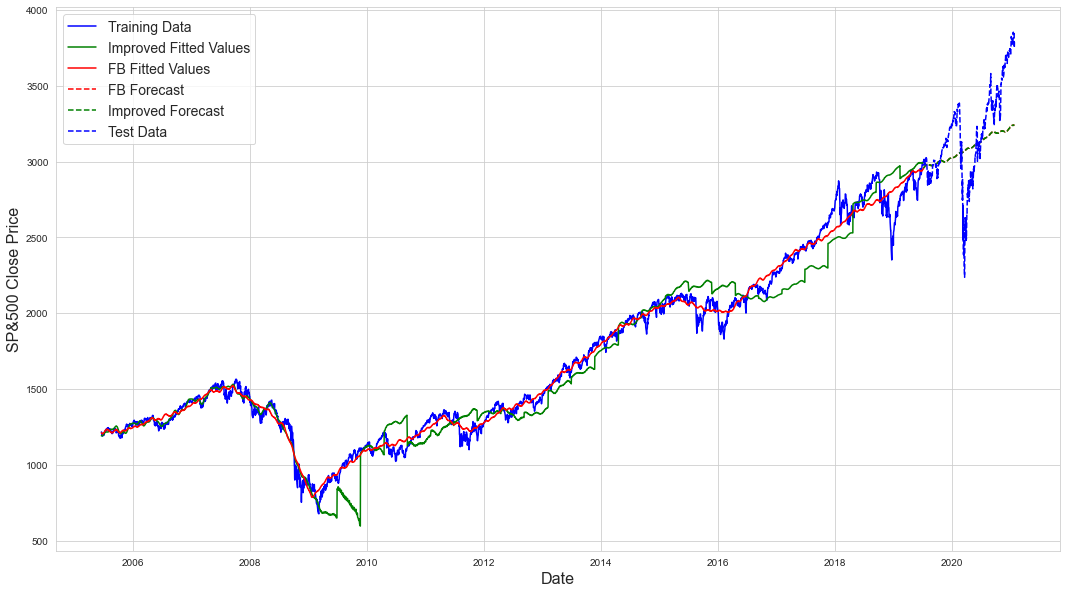

In [43]:
plt.figure(figsize=(18,10))

# plot the training data
plt.plot(df_train.ds,df_train.y,'b',
            label = "Training Data")

plt.plot(df_train.ds,df_train.fbsp,'g-',
            label = "Improved Fitted Values")

# plot the fit
plt.plot(df_train.ds, fc_df[:cutoff].fbsp,'r-',
            label = "FB Fitted Values")

# # plot the forecast
plt.plot(df_test.ds, fc_df[cutoff:].fbsp,'r--', label = "FB Forecast")
plt.plot(df_test.ds,  df_test.fbsp,'g--',label = "Improved Forecast")
plt.plot(df_test.ds, df_test.y,'b--', label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Date", fontsize=16)
plt.ylabel("SP&500 Close Price", fontsize=16)

plt.show()

In [54]:
pd.concat([df_train,df_test])

,ds,y,tby,ffr,fta,eps,div,une,vix,fbsp
0,2005-06-20,1216.10,4.11,3.04,812235.0,84.81,1.76,5.0,148.30,1191.449597
1,2005-06-21,1213.61,4.06,3.04,812235.0,84.81,1.76,5.0,149.00,1191.955579
2,2005-06-22,1213.88,3.95,3.04,811179.0,84.81,1.76,5.0,148.40,1191.695653
3,2005-06-23,1200.73,3.96,3.04,811179.0,84.81,1.76,5.0,150.50,1190.749328
4,2005-06-24,1191.57,3.92,3.04,811179.0,84.81,1.76,5.0,152.00,1190.746134
...,...,...,...,...,...,...,...,...,...,...
3892,2021-01-22,3841.47,1.10,0.09,7414942.0,95.72,1.58,6.3,24.85,3241.237695
3893,2021-01-25,3855.36,1.05,0.09,7414942.0,95.72,1.58,6.3,25.85,3240.331223
3894,2021-01-26,3849.62,1.05,0.09,7414942.0,95.72,1.58,6.3,25.30,3240.225441
3895,2021-01-27,3750.77,1.04,0.09,7404926.0,95.72,1.58,6.3,33.05,3240.196615


In [51]:
df_test

,ds,y,tby,ffr,fta,eps,div,une,vix,fbsp
3508,2019-07-10,2993.07,2.07,2.40,3815038.0,139.88,1.94,3.6,14.10,2956.281317
3509,2019-07-11,2999.91,2.13,2.40,3815038.0,139.88,1.94,3.6,13.70,2958.524203
3510,2019-07-12,3013.77,2.12,2.40,3815038.0,139.88,1.94,3.6,13.12,2960.942015
3511,2019-07-15,3014.30,2.09,2.40,3815038.0,139.88,1.94,3.6,12.91,2961.954607
3512,2019-07-16,3004.04,2.13,2.40,3815038.0,139.88,1.94,3.6,12.90,2964.083755
...,...,...,...,...,...,...,...,...,...,...
3892,2021-01-22,3841.47,1.10,0.09,7414942.0,95.72,1.58,6.3,24.85,3241.237695
3893,2021-01-25,3855.36,1.05,0.09,7414942.0,95.72,1.58,6.3,25.85,3240.331223
3894,2021-01-26,3849.62,1.05,0.09,7414942.0,95.72,1.58,6.3,25.30,3240.225441
3895,2021-01-27,3750.77,1.04,0.09,7404926.0,95.72,1.58,6.3,33.05,3240.196615


In [57]:
df2 = df.copy()
df2['fbsp1'] = fc_df.fbsp
df2['diff1'] =  df2['y'] - df2['fbsp1']
df2['fbsp2'] = pd.concat([df_train,df_test]).fbsp
df2['diff2'] = df2['y'] - df2['fbsp2']


In [64]:
df2 = df2.dropna()
df2['ds'] = pd.to_datetime(df2['ds'])
df2 = df2.set_index(df2['ds'])
df2 = df2.drop(columns=['ds'])
df2

,y,tby,ffr,fta,eps,div,une,vix,fbsp1,diff1,fbsp2,diff2
ds,,,,,,,,,,,,
2005-06-20,1216.10,4.11,3.04,812235.0,84.81,1.76,5.0,148.30,1209.129964,6.970036,1191.449597,24.650403
2005-06-21,1213.61,4.06,3.04,812235.0,84.81,1.76,5.0,149.00,1210.664979,2.945021,1191.955579,21.654421
2005-06-22,1213.88,3.95,3.04,811179.0,84.81,1.76,5.0,148.40,1208.870419,5.009581,1191.695653,22.184347
2005-06-23,1200.73,3.96,3.04,811179.0,84.81,1.76,5.0,150.50,1208.073692,-7.343692,1190.749328,9.980672
2005-06-24,1191.57,3.92,3.04,811179.0,84.81,1.76,5.0,152.00,1207.561792,-15.991792,1190.746134,0.823866
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-22,3841.47,1.10,0.09,7414942.0,95.72,1.58,6.3,24.85,3241.237695,600.232305,3241.237695,600.232305
2021-01-25,3855.36,1.05,0.09,7414942.0,95.72,1.58,6.3,25.85,3240.331223,615.028777,3240.331223,615.028777
2021-01-26,3849.62,1.05,0.09,7414942.0,95.72,1.58,6.3,25.30,3240.225441,609.394559,3240.225441,609.394559


In [65]:
df2.to_csv(r'/Users/yuqingdai/Documents/GitHub/Stock-Erdos/scratch work/Yuqing-Data-Merge/dff4.csv')